In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import albumentations as A
import pickle

from torch.utils.data import DataLoader, random_split
from helpers.utils import get_car_filenames, show_img_mask, compute_resize_shape_and_max_depth
from helpers.datasets import CarDataset

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

# 1. Dataset

In [4]:
# image_shape = (1280, 1918)
# h_resize, w_resize, depth = compute_resize_shape_and_max_depth(*image_shape)
# h_resize, w_resize, depth

In [5]:
transforms = [
    A.Resize(128, 256),
    A.Rotate(limit=20),
    A.Flip(),
    A.ColorJitter()
]

split_ratio = 0.7
train_dataset = CarDataset(*get_car_filenames(), dataset_expand_ratio=3, transforms=transforms)
split_pt = int(len(train_dataset) * split_ratio)
train_dataset, eval_dataset = random_split(train_dataset, [split_pt, len(train_dataset) - split_pt])
test_dataset = CarDataset(*get_car_filenames(mode="test"), transforms=[A.Resize(128, 256)])
print(f"#training samples: {len(train_dataset)}, #eval_samples: {len(eval_dataset)}, #test samples: {len(test_dataset)}")

#training samples: 201, #eval_samples: 87, #test samples: 3


index: 144
torch.Size([3, 128, 256]), torch.Size([128, 256])


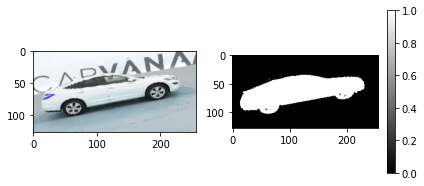

In [6]:
# visualize the dataset
index = np.random.randint(0, len(train_dataset))
print(f"index: {index}")
img, mask = train_dataset[index]
print(f"{img.shape}, {mask.shape}")
show_img_mask(img=img.permute(1, 2, 0).numpy(), mask=mask.numpy())

In [7]:
train_loader_args = dict(batch_size=8, shuffle=True, num_workers=0)
eval_loader_args = dict(batch_size=8, shuffle=False, num_workers=0)
test_loader_args = dict(batch_size=len(test_dataset), num_workers=0)
train_loader = DataLoader(train_dataset, **train_loader_args)
eval_loader = DataLoader(eval_dataset, **eval_loader_args)
test_loader = DataLoader(test_dataset, **test_loader_args)

In [8]:
for imgs, masks in train_loader:
    print(f"{imgs.shape}, {masks.shape}")
    break

torch.Size([8, 3, 128, 256]), torch.Size([8, 128, 256])


# 2. Model

In [9]:
from models.u_net import UNet

In [10]:
u_net = UNet(num_down_blocks=3, target_channels=2).to(DEVICE)

# 3. Training

In [11]:
# lr_finder
from helpers.train_eval import lr_search

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.87E-04


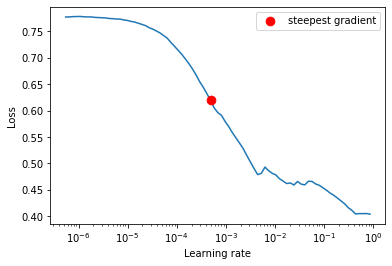

In [14]:
optimizer = torch.optim.Adam(u_net.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()
lr_history = lr_search(u_net, criterion, optimizer, train_loader, end_lr=2, device=DEVICE)

In [15]:
# training
min_lr, max_lr = 1e-4, 3e-3
lr = 4.87e-4
optimizer = torch.optim.Adam(u_net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, 
                                              step_size_up=len(train_loader) // 2, cycle_momentum=False)

In [16]:
from helpers.train_eval import CarTrainer

In [17]:
car_trainer = CarTrainer(u_net, train_loader, eval_loader, optimizer, scheduler, DEVICE, epochs=30)

epochs:   0%|          | 0/30 [00:00<?, ?it/s]

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

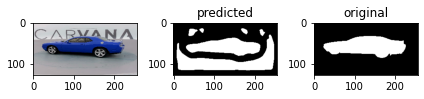

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

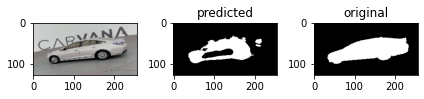

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

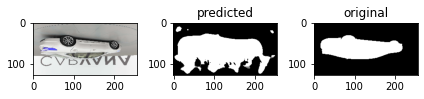

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

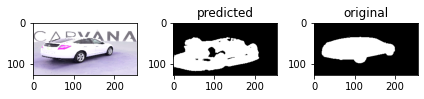

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

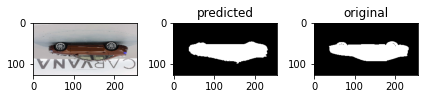

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

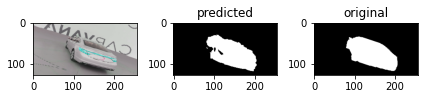

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

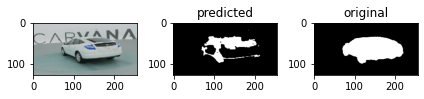

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

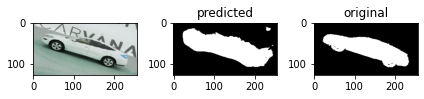

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

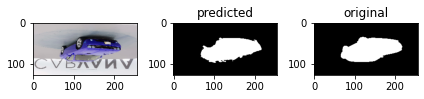

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

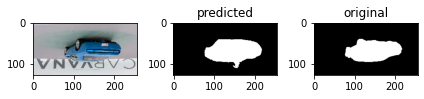

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

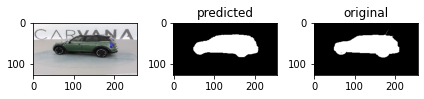

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

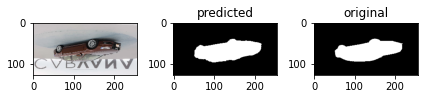

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

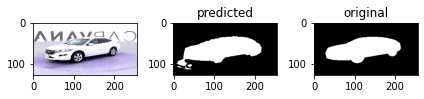

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

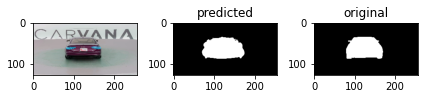

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

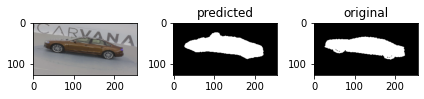

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

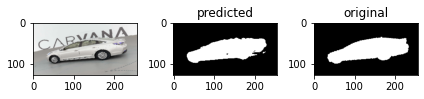

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

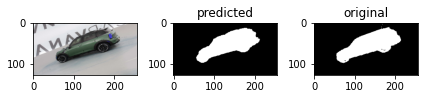

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

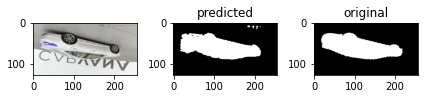

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

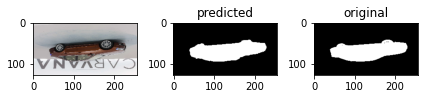

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

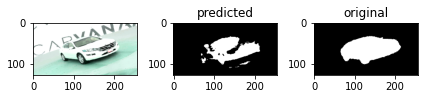

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

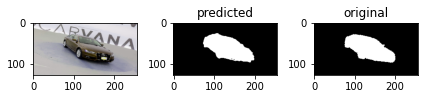

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

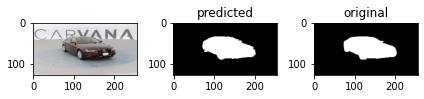

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

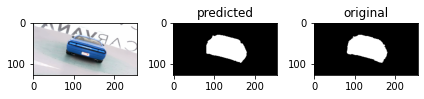

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

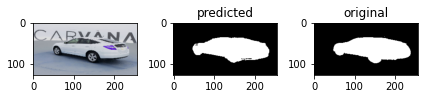

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

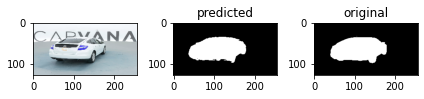

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

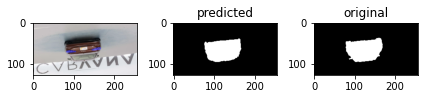

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

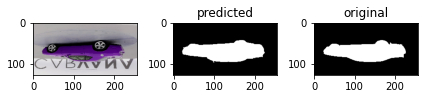

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

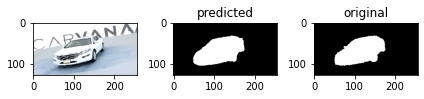

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

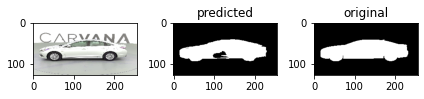

training:   0%|          | 0/26 [00:00<?, ?it/s]

eval:   0%|          | 0/11 [00:00<?, ?it/s]

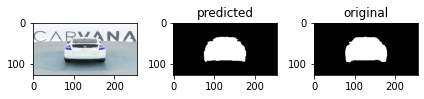

In [18]:
train_losses, eval_losses, lr_rates = car_trainer.train(if_plot=True)

In [22]:
# save_path = "./params/car/1635177271_628721/training.pkl"
# with open(save_path, "wb") as wf:
#     pickle.dump([train_losses, eval_losses, lr_rates], wf)

# 4. Evaluation

## 4.1 Plot Training Curve

In [9]:
from models.u_net import UNet

model_path = "./params/car/1635177271_628721/epoch_30_eval_loss_0_0211.pt"
loss_path = "./params/car/1635177271_628721/training.pkl"
u_net_reload = UNet(num_down_blocks=3, target_channels=2).to(DEVICE)

In [10]:
u_net_reload.load_state_dict(torch.load(model_path))
u_net_reload.eval()
print(end="")

In [11]:
with open(loss_path, "rb") as rf:
    train_losses, eval_losses, lr_rates = pickle.load(rf)

In [12]:
from helpers.utils import plot_training_history, plot_lr

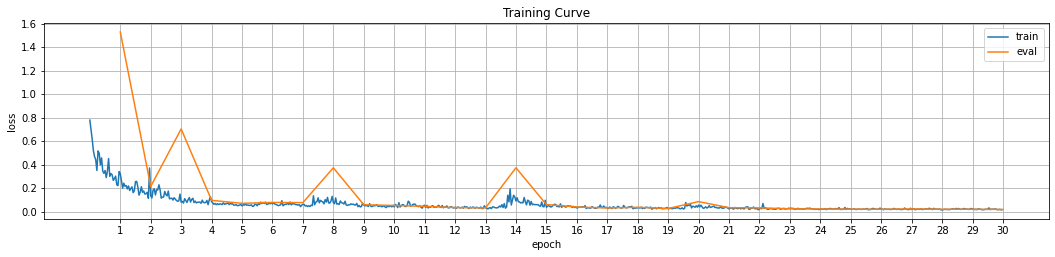

In [13]:
plot_training_history(train_losses, eval_losses, figsize=(18, 3.6))

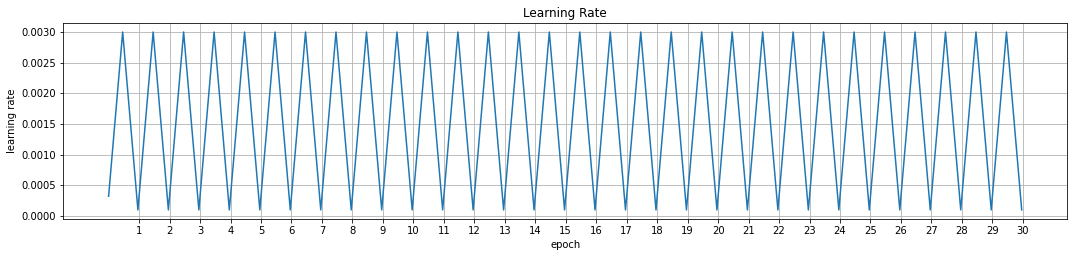

In [14]:
plot_lr(lr_rates, figsize=(18, 3.6))

## 4.2 Prediction on Test Set

In [15]:
from helpers.train_eval import predict, visualize_predictions

In [16]:
for imgs, masks in test_loader:
    break

In [19]:
_, masks_pred = predict(u_net_reload, imgs, DEVICE)

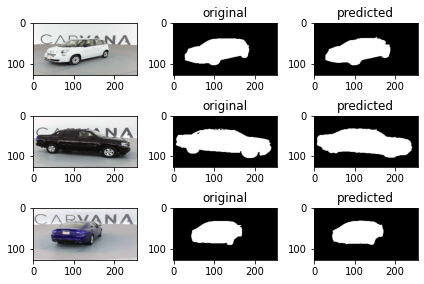

In [20]:
visualize_predictions(imgs, masks, masks_pred, indices=list(range(imgs.shape[0])))